<a href="https://colab.research.google.com/github/aborbala/tree-canopy/blob/main/02_02_training_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Training Data Preparation for YOLO Instance Segmentation

Organizes cropped tile images and annotations into YOLO-compatible dataset format
with train/validation splits and dataset configuration.

Overview:
    Prepares inner tile images and YOLO annotations for object detection training
    by organizing files into train/validation directories and generating YOLO dataset
    configuration file.

Main Sections:

    1. Configuration - Set input/output directories for tiles and annotations
    2. Data Inventory - Count image and annotation files
    3. Train/Validation Split - Shuffle and split dataset (80/20 default)
    4. File Organization - Copy images and labels to YOLO directory structure
    5. Dataset Configuration - Generate dataset.yaml for YOLO training
    6. Visualization - Plot annotations with YOLO and GeoJSON overlays

Key Data:

    Input:
    - Inner tile images (.tif format)
    - YOLO annotations (.txt format with polygon coordinates)
    - GeoJSON geometries (for reference)
    
    Output:
    - YOLO dataset directory with train/val splits
    - Dataset configuration file (dataset.yaml)

Processing Parameters:

    - Train/validation split: 80/20
    - Image format: .tif (grayscale)
    - Annotation format: YOLO instance segmentation (.txt)
    - Class labels: 0=no_cadaster, 1=intersect_cadaster

Key Features:

    - Automatic file shuffling and splitting
    - Directory structure creation for YOLO format
    - Dataset.yaml generation for ultralytics training
    - Annotation visualization with class-based coloring
    - GeoJSON reference overlay for validation

Workflow:

    1. Inventory inner tiles and annotations
    2. Shuffle and split files (80% train, 20% validation)
    3. Copy images and labels to YOLO-compatible directories
    4. Generate dataset.yaml configuration
    5. Visualize sample annotations with overlays
"""

# --- Setup ---

In [26]:
#!pip install ultralytics==8.3.111

In [ ]:
!pip install geopandas shapely opencv-python tqdm rasterio

import os
import random
import shutil
import json
import geopandas as gpd
import cv2
import numpy as np
from tqdm import tqdm
from shapely.geometry import Polygon
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# --- Configuration ---

In [ ]:
# WD
base_dir = "/content/drive/MyDrive/masterthesis/data/386_5818"
inner_tiles_dir = os.path.join(base_dir, "inner_tiles")

# Only lidR
# inner_annotations_dir = os.path.join(base_dir, "inner_annotations")

# Veg mask dataset
inner_annotations_dir = os.path.join(base_dir, "inner_annotations_no_structures_veg_mask")


image_dir   = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles"
label_dir   = "/content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations_no_structures_veg_mask"
geojson_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/crowns_clean_no_structures_veg_mask"
train_label_dir = "/content/drive/MyDrive/masterthesis/data/386_5818/yolo_dataset_no_structures_veg_mask/labels/train"



In [ ]:
# Output directory for YOLO dataset
output_dir = os.path.join(base_dir, "yolo_dataset_no_structures_veg_mask")
yolo_images_dir = os.path.join(output_dir, "images")
yolo_labels_dir = os.path.join(output_dir, "labels")

os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(yolo_images_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(yolo_images_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(yolo_labels_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(yolo_labels_dir, "val"), exist_ok=True)

print(f"YOLO dataset directories set up under: {output_dir}")

✅ YOLO dataset directories set up under: /content/drive/MyDrive/masterthesis/data/386_5818/yolo_dataset_no_structures_veg_mask


In [ ]:
# Check number of image files
image_files = [f for f in os.listdir(inner_tiles_dir) if f.endswith(".tif")]
annotation_files = [f for f in os.listdir(inner_annotations_dir) if f.endswith("_inner.txt")]

print(f"Found {len(image_files)} inner tile images in {inner_tiles_dir}")
print(f"Found {len(annotation_files)} annotation files in {inner_annotations_dir}")


📸 Found 676 inner tile images in /content/drive/MyDrive/masterthesis/data/386_5818/inner_tiles
📝 Found 671 annotation files in /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations_no_structures_veg_mask


Run only to split training data

In [ ]:
import random
import shutil
from tqdm import tqdm

# Shuffle and split dataset
random.shuffle(image_files)
split_idx = int(len(image_files) * 0.8)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Copy images and annotations into YOLO format
for file in tqdm(image_files, desc="Copying images & labels"):
    base_name = file.replace(".tif", "")
    image_src = os.path.join(inner_tiles_dir, file)
    label_src = os.path.join(inner_annotations_dir, f"{base_name}_inner.txt")  # Ensure correct annotation name

    # Define destination folders
    if file in train_files:
        shutil.copy(image_src, os.path.join(yolo_images_dir, "train", file))
        if os.path.exists(label_src):
            shutil.copy(label_src, os.path.join(yolo_labels_dir, "train", f"{base_name}.txt"))
    else:
        shutil.copy(image_src, os.path.join(yolo_images_dir, "val", file))
        if os.path.exists(label_src):
            shutil.copy(label_src, os.path.join(yolo_labels_dir, "val", f"{base_name}.txt"))

print(f"Successfully copied {len(train_files)} train and {len(val_files)} val samples!")


Copying images & labels: 100%|██████████| 676/676 [02:58<00:00,  3.79it/s]

✅ Successfully copied 540 train and 136 val samples!


In [ ]:
train_images = os.listdir(os.path.join(yolo_images_dir, "train"))
train_labels = os.listdir(os.path.join(yolo_labels_dir, "train"))

val_images = os.listdir(os.path.join(yolo_images_dir, "val"))
val_labels = os.listdir(os.path.join(yolo_labels_dir, "val"))

print(f"Train images: {len(train_images)}, Labels: {len(train_labels)}")
print(f"Validation images: {len(val_images)}, Labels: {len(val_labels)}")

🖼️ Train images: 540, Labels: 536
🖼️ Validation images: 136, Labels: 135


In [26]:
#!rm -rf /content/drive/MyDrive/masterthesis/data/386_5818/yolo_dataset/labels/*.cache
#!rm -rf /content/drive/MyDrive/masterthesis/data/386_5818/yolo_dataset_veg_mask/labels/*.cache

!rm -rf /content/drive/MyDrive/masterthesis/data/386_5818/yolo_dataset_no_structures_veg_mask/labels/*.cache

In [ ]:
dataset_yaml = f"""
path: {output_dir}
train: images/train
val:   images/val
nc: 2
names: ["no_cadaster", "intersect_cadaster"]
task: segment
"""

with open(os.path.join(output_dir, "dataset.yaml"), "w") as f:
    f.write(dataset_yaml)

print("Created dataset.yaml for YOLO training!")


✅ Created dataset.yaml for YOLO training!


In [ ]:
annotation_files = [f for f in os.listdir(inner_annotations_dir) if f.endswith(".txt")]

if annotation_files:
    sample_label = os.path.join(inner_annotations_dir, annotation_files[0])  # Pick first annotation file
    print(f"Sample annotation file: {sample_label}")
else:
    print("No annotation files found!")


📄 Sample annotation file: /content/drive/MyDrive/masterthesis/data/386_5818/inner_annotations_no_structures_veg_mask/3dm_33_386_5818_1_be_nobuild_81_inner.txt


# --- Visualisation ---

Image: 3dm_33_386_5818_1_be_nobuild_1.tif
YOLO Label: 3dm_33_386_5818_1_be_nobuild_1_inner.txt
GeoJSON: 3dm_33_386_5818_1_be_nobuild_1.geojson (exists: True)


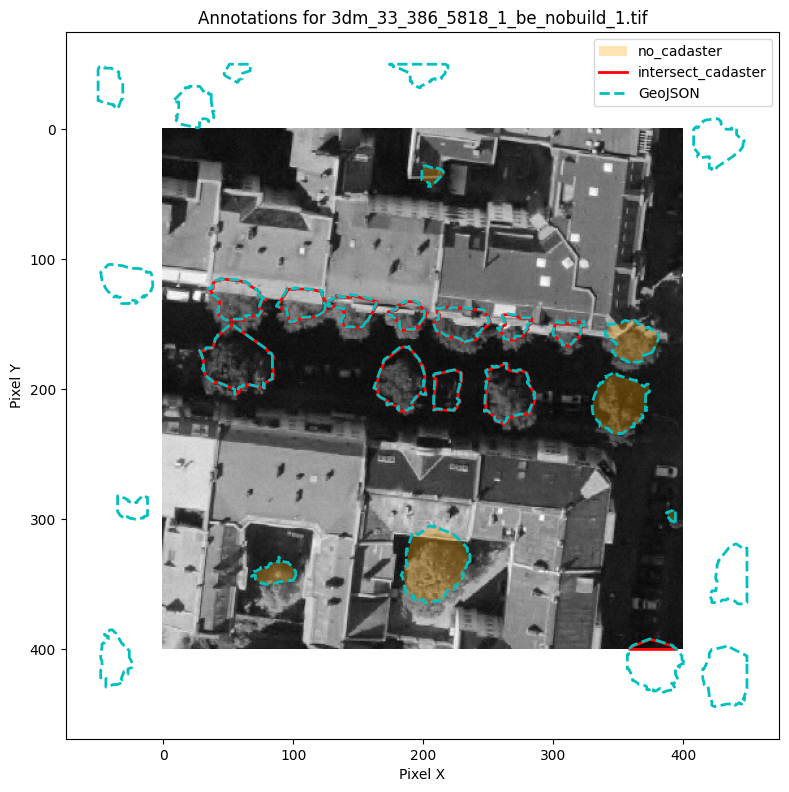

In [ ]:
def plot_annotations(image_path, label_path, geojson_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        height, width = image.shape

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap="gray", origin="upper")

    # -- Plot YOLO annotations --
    first_poly = True
    first_line = True

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls_id, *pts = line.strip().split()
                cls_id = int(cls_id)
                coords = np.array(pts, float).reshape(-1, 2)
                coords[:, 0] *= width
                coords[:, 1] *= height
                coords = np.vstack([coords, coords[0]])  # close

                if cls_id == 0:
                    lbl = "no_cadaster" if first_poly else None
                    patch = MplPolygon(coords, closed=True,
                                       facecolor="orange", edgecolor="none",
                                       alpha=0.3, label=lbl)
                    ax.add_patch(patch)
                    first_poly = False
                else:
                    lbl = "intersect_cadaster" if first_line else None
                    ax.plot(coords[:, 0], coords[:, 1], "r-",
                            linewidth=2, label=lbl)
                    first_line = False

    # -- Plot original GeoJSON as cyan dashed lines --
    first_geo = True
    if os.path.exists(geojson_path):
        gdf = gpd.read_file(geojson_path)
        with rasterio.open(image_path) as src2:
            for geom in gdf.geometry:
                if geom.geom_type == "Polygon":
                    coords = list(geom.exterior.coords)
                    pixels = np.array([
                        [col, row] for row, col in
                        (src2.index(x, y) for x, y in coords)
                    ])
                    lbl = "GeoJSON" if first_geo else None
                    ax.plot(pixels[:, 0], pixels[:, 1], "c--",
                            linewidth=2, label=lbl)
                    first_geo = False

    ax.set_xlabel("Pixel X")
    ax.set_ylabel("Pixel Y")
    ax.set_title(f"Annotations for {os.path.basename(image_path)}")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# Select the 17th image (0-based index 16)
image_files = sorted(f for f in os.listdir(image_dir) if f.endswith(".tif"))

sample_image = image_files[1]
base_name = os.path.splitext(sample_image)[0]
image_path = os.path.join(image_dir, sample_image)
label_path = os.path.join(label_dir, f"{base_name}_inner.txt")
geojson_path = os.path.join(geojson_dir, f"{base_name}.geojson")

print(f"Image: {sample_image}")
print(f"YOLO Label: {base_name}_inner.txt")
print(f"GeoJSON: {base_name}.geojson (exists: {os.path.exists(geojson_path)})")
plot_annotations(image_path, label_path, geojson_path)